# Preprocess Data from Preprocessing file

In [17]:
import os
from Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# change this accordingly but should work for all users
glioma_path = my_dir[:-15] + "/data/glioma_tumor"
meningioma_path = my_dir[:-15] + "/data/meningioma_tumor"
pituitary_path = my_dir[:-15] + "/data/pituitary_tumor"
normal_path = my_dir[:-15] + "/data/normal_tumor"


# preprocess data
n_samples = 200 # good starting point to train model
seed = 42 # reproducibility
glioma_data, glioma_labels = preprocess_data(glioma_path, n_samples, seed)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, n_samples, seed)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, n_samples, seed)
normal_data, normal_labels = preprocess_data(normal_path, n_samples, seed)
if glioma_data.shape != meningioma_data.shape or pituitary_data.shape != normal_data.shape:
    raise ValueError("All data must have the same shape")
else:
    print("All data have the same shape")

# combine all data and labels
data = np.concatenate([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.concatenate([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])
print(f"Combined data and labels shape: {data.shape}, {labels.shape}")

# split data into training and testing and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_small, val_data, train_small_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# one hot encode labels
label_encoder = OneHotEncoder()
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))

Current working directory: /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts
All data have the same shape
Combined data and labels shape: (800, 256, 256, 1), (800,)


# Visually Inspect

Training labels as one hot encoded: [['meningioma']
 ['normal']
 ['meningioma']
 ['meningioma']
 ['meningioma']]


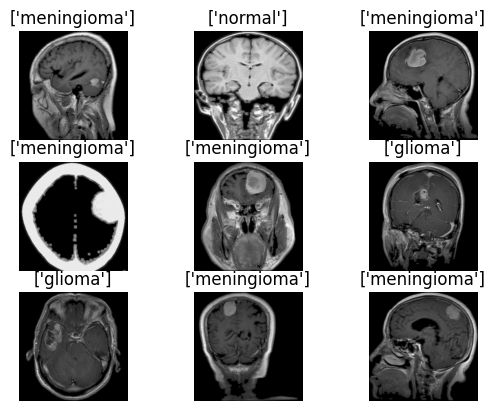

In [13]:
# inverse transform labels
labels = label_encoder.inverse_transform(train_labels)

# show images from training set
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i], cmap="gray")
    plt.axis('off')
    plt.title((labels[i]))
plt.show()

# Modeling
- We first can start with a simple convolution model to see how well a few different architectures will pick up on the training data set,
- Then we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras

# Simple CNN to Start
### Model Flow
- In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.
- After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.
- Then after another round of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers
- Finally the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [5]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(256, 256, 1))) # 3x3 is the kernel size, 32 is the number of filters
model.add(MaxPooling2D(2))
# input rest of model here


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,509,508 (120.20 MB)

 Trainable params: 31,509,508 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

# TODO LATER once decent performance on simple CNN:
HyperParameter Tuning
- Using Hyperband from kerastuners, we can define a function to build the best model.
- After finding the best model, we can then build a new model to train.

In [2]:
# building a hyperband model to find the best model architecture
import kerastuner as kt
from kerastuner.tuners import Hyperband
def build_model(hp):
    '''Hyperband function to test different model architectures'''
    model = Sequential()
    model.add(Conv2D(units=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16), # find the best number of filters
                     kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
                     activation='relu'), input_shape=(256, 256))
    model.add(MaxPooling2D(2)) # max pooling to reduce the dimensionality of the data
    model.add(Conv2D(units=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16), # find the best number of filters
                     kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
                     activation='relu'))
    model.add(MaxPooling2D(2)) # max pooling to reduce the dimensionality of the data
    model.add(Flatten()) # flatten the data to feed into the dense layers
    model.add(Dense(units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16), # find the best number of units
                    activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1))) # dropout to prevent overfitting
    model.add(Dense(4, activation='softmax')) # pituitary, meningioma, glioma, normal
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])), # find the best learning rate
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model